In [6]:
from google.colab import drive
drive.mount("/content/drive")


ModuleNotFoundError: ignored

In [89]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets ,models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary


from __future__ import print_function, division

from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

#  https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/62840b1eece760d5e42593187847261f/transfer_learning_tutorial.ipynb#scrollTo=dF0_RiFvCP4s


import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [91]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomDNADataset(Dataset):
    def __init__(self, feature_file,label_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(label_file)
        self.img_features = pd.read_csv(feature_file)
        # pandas read the data 
        self.transform = transform
        self.target_transform = target_transform
        # no transform is used here 
        #self.dic= {'-':0,'A' :2**2 , 'C':2**4,'T':2**6,'G':2**7,'N':0}
        self.dic= {'-':[0,0,0,0],'A' :[1,0,0,0] , 'C':[0,1,0,0],'T':[0,0,1,0],'G':[0,0,0,1]}
        # I learned the sequence of dana from file:///D:/downloads/dna-and-animal-classification.pdf
        #and from http://ircamera.as.arizona.edu/Astr2016/text/nucleicacid1.htm 
        # which showed that there are 4 dominante letters to determine the sequence

    def __len__(self):
        return len(self.img_labels)
        # this is just the number rows or samples in the input data as used by 
        # Dataset class 

    def __getitem__(self, idx):
 ############# DNA transform ######################     
        DNA = self.img_features.iloc[idx,1]
        # so DNA is getting the img_features panda csv read and we are taking the second
        #colmn , the first is just ids . idx is generated by pytorch randomly depending on
        # if we shuffle the data or not and the number of batch size (part of Dataset class which
        # we inheret from )


        n = np.array([])
        Our_pad = (3*22*22)-len(DNA)
        # here I am using 1296 which is 36*36 , I choose this number based on 
        # the maximum individual row I found which was around 1058 ,this is used to 
        # generate a padding which is some how consistent along all .I also chose 
        # 36 so that when we do conv and maxpool we get a nice number which is 
        # dividable by 2 How to fix RuntimeError "Expected object 
        #of scalar type Float but got scalar type Double for argument"
        # here to get the right dim we muliply by 2 the in dim 
        
        for i in range(len(DNA)):# DNA is our row where we itterate 

          if DNA[i] in self.dic:
            mut = self.dic[DNA[i]]
            mut = [x * 2 for x in mut]

            n = np.append(n,mut)
          else:
            n= np.append(n,[0,0,0,0])
          
          
        for pad in range(Our_pad):# we pad the end of the sequence with zeros 
          n =np.append(n,[0,0,0,0])

        
        l = np.array(n , dtype=np.float32)
        # this was very trick where the base type of any np array is float 64 or 
        # double but the base type for torch is float 32 so if we convert 
        # a np array to torch we need to first change it to float32 or we get an error 
        # which says 

        # taking only the first 600 
        Data_array = torch.from_numpy(l[0:2400])
        #print(Data_array.shape)
        #transfer a np to torch 
        #DNA_dense = Data_array
        # depending on the type of network we can keep it flat or 
        # change the dim (resh
        DNA_image = Data_array.reshape(3,20,40)


        # reshape the dim to be in the form of an image of pix 1 which is 
        # usally the RGB or gray channel , in our case it is gray ,
        # then 36 by 36 which what our padding is doing 
        #for a 3 chennel image insted of 1 


#################################################
        label = self.img_labels.iloc[idx, 1]
        # we get the labels from a different file 

        return DNA_image, label

In [92]:
train_features_path = '/Users/yousi/Untitled Folder/dna-barcode-classification/data/train_ten_features.csv'
#test_features_path = '/content/drive/MyDrive/Colab Notebooks/deep learning CSCI570/deep learning course/dna-barcode-classification/test_features.csv'
train_labels_path = '/Users/yousi/Untitled Folder/dna-barcode-classification/data/train_ten_labels.csv'
#test_labels_path = '/content/drive/MyDrive/Colab Notebooks/deep learning CSCI570/deep learning course/dna-barcode-classification/train_labels - Copy.csv'


full_dataset= CustomDNADataset(feature_file=train_features_path,label_file=train_labels_path)
# so pass the whole set by specifing the path of file to be inputed to our custum class 

#Test_dataset = CustomDNADataset(feature_file=test_features_path,label_file=test_labels_path)
# for the test_dataset I am using fake label data which is not accually there just so that I can use 
# my custom class , it has the same len as the train data ( I choped some in csv file )

In [93]:
# ############preprocessing to get the 10 most frequent dna sequences and their labels###################################################



# test = pd.read_csv(train_labels_path)
# test.head()
# t = pd.read_csv(train_labels_path)
# f = pd.read_csv(train_features_path)
# t['freq'] = t['labels'].value_counts()
# t = t.sort_values('freq',ascending=False)
# t = t.dropna()
# t = t['labels'].iloc[0:10]
# t.head()
# # print(t)





# target_labels_list = t.values.tolist()
# # print(target_labels_list)
# labels_list = test.values.tolist()
# # print(labels_list)



# target_index = []
# target_labels = []
# for target in target_labels_list:
#   for small_list in labels_list:
#     if target ==small_list[1]:
#       #print(small_list)
#       target_index.append(small_list[0])
#       target_labels.append(target)




# len(target_index)
# #print(target_labels)
# df = pd.DataFrame(target_labels, columns=["DNA"])
# df.to_csv('train_ten_labels.csv', index=True)
# df.head()


# target_features_list = f.values.tolist()
# # print(len(target_features_list))
# # print(target_features_list[1])

# target_features = []
# for target in target_index:
#   #print(target)
#   for small_list in target_features_list:
#     if target ==small_list[0]:
#       #print(small_list)
#       target_features.append(small_list[1])

# len(target_features)
# df = pd.DataFrame(target_features, columns=["DNA"])
# df.to_csv('train_ten_features.csv', index=True)
# df.head()
# full_dataset.img_labels.shape



In [105]:
latent_dims = 2

data = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=32,
        shuffle=True)


In [145]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3,10,9)
        self.linear1 = nn.Linear(3840, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        # print(x.shape,'x_shape')
        x = self.conv1(x)
        # print(x.shape,'x_shape after conv1')
        x = torch.flatten(x, start_dim=1)
        x = torch.flatten(x, start_dim=1)
        # print(x.shape,'x_shape after flatten')
        x = F.relu(self.linear1(x))
        # print(x.shape,'x_shape after linear1')
        return self.linear2(x)

In [146]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.convT = nn.ConvTranspose2d(latent_dims , 10,9)
        self.linear1 = nn.Linear(810, 900)
        self.linear2 = nn.Linear(900, 3*20*40)
        
    def forward(self, z):
        z = z.view(-1,latent_dims, 1, 1)
        # print(z.shape , 'zshape ')
        z = self.convT(z)
        # print(z.shape , 'zshape  after t cov')
        z = torch.flatten(z, start_dim=1)
        z = torch.flatten(z, start_dim=1)
        # print(z.shape , 'after flatten ')
        z = F.relu(self.linear1(z))
        # print(z.shape , 'zshape  after linear1')
        z = torch.sigmoid(self.linear2(z))
        # print(z.shape , 'zshape  after linear2')
        return z.view(-1,3, 20, 40)

In [147]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        #print('auto encoder done ')
        return self.decoder(z)

In [148]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            #print(1)
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            #print(2)
            loss = ((x - x_hat)**2).sum()
            #print(3)
            loss.backward()
            #print(4)
            opt.step()
    return autoencoder

In [149]:
autoencoder = Autoencoder(latent_dims).to(device) # GPU

autoencoder = train(autoencoder, data)

In [150]:


def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        
        print(x.shape,y.shape,z.shape)
        
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')

        if i > num_batches:
            plt.colorbar()
            break





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 12]           2,440
            Linear-2                  [-1, 512]       1,966,592
            Linear-3                    [-1, 2]           1,026
           Encoder-4                    [-1, 2]               0
   ConvTranspose2d-5             [-1, 10, 9, 9]           1,630
            Linear-6                  [-1, 900]         729,900
            Linear-7                 [-1, 2400]       2,162,400
           Decoder-8            [-1, 3, 20, 40]               0
Total params: 4,863,988
Trainable params: 4,863,988
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.08
Params size (MB): 18.55
Estimated Total Size (MB): 18.65
----------------------------------------------------------------
torch.Size([32, 3, 20, 40]) torch.Si

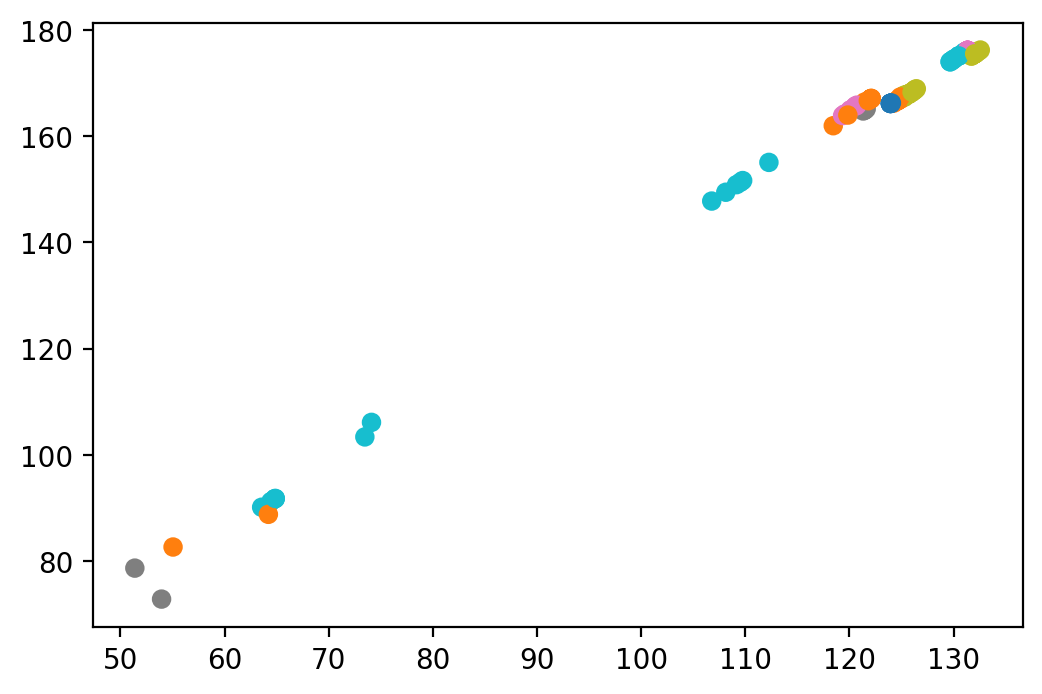

In [151]:
summary(autoencoder, (3, 40, 20))

############# ploting autoencoder without the using VAE technique
plot_latent(autoencoder, data)


In [156]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(2400, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [157]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

In [158]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [159]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

Let's plot the latent vector representations of a few batches of data.

torch.Size([32, 3, 20, 40]) torch.Size([32]) (32, 2)
torch.Size([32, 3, 20, 40]) torch.Size([32]) (32, 2)
torch.Size([32, 3, 20, 40]) torch.Size([32]) (32, 2)
torch.Size([25, 3, 20, 40]) torch.Size([25]) (25, 2)


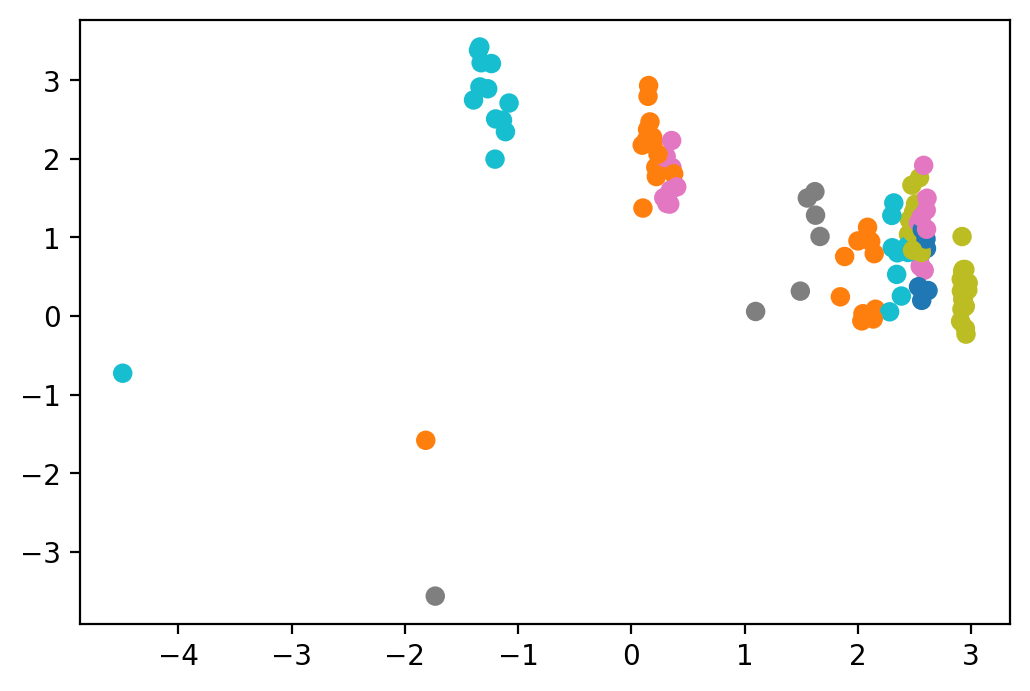

In [160]:
############# ploting autoencoder using VAE technique #######################
plot_latent(vae, data)



In [161]:
#######################################################Creating the 50 dim latent embedding for the full set #############################################################################################################
class Custom_latent(Dataset):
    def __init__(self, featureZ,label, transform=None, target_transform=None):
        self.img_labels =label
        self.img_features = featureZ
        # pandas read the data 
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
        # this is just the number rows or samples in the input data as used by 
        # Dataset class 

    def __getitem__(self, idx):
 ############# DNA transform ######################     
        DNA = self.img_features[idx]

        Data_array = torch.from_numpy(DNA)

        #DNA_image = Data_array.reshape(5808)



#################################################
        label = self.img_labels[idx]
        # we get the labels from a different file 

        return Data_array, label



In [162]:
###################generate the latent matrix for training ###########################


train_features_path = '/Users/yousi/Untitled Folder/dna-barcode-classification/data/train_features.csv'
test_features_path = '/Users/yousi/Untitled Folder/dna-barcode-classification/data/test_features.csv'
train_labels_path = '/Users/yousi/Untitled Folder/dna-barcode-classification/data/train_labels.csv'
test_labels_path = '/Users/yousi/Untitled Folder/dna-barcode-classification/data/train_labels - Copy.csv'


full_dataset= CustomDNADataset(feature_file=train_features_path,label_file=train_labels_path)
# so pass the whole set by specifing the path of file to be inputed to our custum class 

Test_dataset = CustomDNADataset(feature_file=test_features_path,label_file=test_labels_path)
# for the test_dataset I am using fake label data which is not accually there just so that I can use 
# my custom class , it has the same len as the train data ( I choped some in csv file )

data = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=32,
        shuffle=True)




############# train for 50 latent_dim ########################
latent_dims = 50
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

In [164]:
################## create the Dataloader for our data to be feed into a NN #####################

data_train = torch.utils.data.DataLoader(
        full_dataset,
        batch_size=15000,
        shuffle=True)



def from_latent_to_featuresand_Labels (autoencoder,data):
  for i,(x,y) in enumerate(data):
    z = autoencoder.encoder(x.to(device))
    print(y.shape,z.shape)

    #z = z.to('cpu').detach().numpy()
    return (z , y)


featureZ , features_labels = from_latent_to_featuresand_Labels(vae,data_train)
#print(featureZ.shape,labels.shape)










torch.Size([12906]) torch.Size([12906, 50])
torch.Size([12906]) torch.Size([12906, 50])


In [183]:


Test_dataset = CustomDNADataset(feature_file=test_features_path,label_file=test_labels_path)

data_test = torch.utils.data.DataLoader(
        Test_dataset,
        batch_size=15000,
        shuffle=False)
testZ , test_labels = from_latent_to_featuresand_Labels(vae,data_test)

new_dataset_train = Custom_latent(featureZ.to('cpu').detach().numpy() , features_labels )
new_dataset_test = Custom_latent(testZ.to('cpu').detach().numpy() , test_labels )


new_dataLoader_train = torch.utils.data.DataLoader(
        new_dataset_train,
        batch_size=32,
        shuffle=True)

torch.Size([8306]) torch.Size([8306, 50])


In [182]:
# for i, (images, labels) in enumerate(new_dataset_test):
    # print(i ,images.shape , labels)

Streaming output truncated to the last 5000 lines.
7906 torch.Size([50]) tensor(904)
7907 torch.Size([50]) tensor(1185)
7908 torch.Size([50]) tensor(591)
7909 torch.Size([50]) tensor(406)
7910 torch.Size([50]) tensor(573)
7911 torch.Size([50]) tensor(417)
7912 torch.Size([50]) tensor(974)
7913 torch.Size([50]) tensor(1071)
7914 torch.Size([50]) tensor(31)
7915 torch.Size([50]) tensor(68)
7916 torch.Size([50]) tensor(1065)
7917 torch.Size([50]) tensor(327)
7918 torch.Size([50]) tensor(541)
7919 torch.Size([50]) tensor(841)
7920 torch.Size([50]) tensor(626)
7921 torch.Size([50]) tensor(814)
7922 torch.Size([50]) tensor(802)
7923 torch.Size([50]) tensor(1112)
7924 torch.Size([50]) tensor(298)
7925 torch.Size([50]) tensor(1069)
7926 torch.Size([50]) tensor(1108)
7927 torch.Size([50]) tensor(310)
7928 torch.Size([50]) tensor(605)
7929 torch.Size([50]) tensor(172)
7930 torch.Size([50]) tensor(312)
7931 torch.Size([50]) tensor(190)
7932 torch.Size([50]) tensor(467)
7933 torch.Size([50]) tenso

In [169]:
class NN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.fc1 = nn.Linear(50, 250)
        self.fc2 = nn.Linear(250, 840)
        self.fc3 = nn.Linear(840, num_classes)
        self.dropout = nn.Dropout(0.50)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x





In [170]:
# set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# hyper parameters 
input_size = 36*36
in_channel = 1
num_classes = 1214
learning_rate = 0.001
batch_size = 15
num_epochs = 5
#
model = NN(num_classes).to(device)

#loss and optimizer 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr= learning_rate)

In [176]:
# train Network on the 50 dim created from the steps ###################
for epoch in range (num_epochs):
  for batch_ind ,(data1, targets) in enumerate(new_dataLoader_train):
    data1 = data1.to(device = device)
    targets = targets.to(device = device)

    #print(data.shape)

    # forward
    scores = model(data1)
    loss = criterion(scores , targets)

    # backword 

    optimizer.zero_grad()
    loss.backward()


    # gradient descent or adam step

    optimizer.step()
    #print(loss.item())

    



    #check the accuracy on validation data 

  def check_accuracy (loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
      for x,y in loader:
        x = x.to(device = device )
        y = y.to(device = device)
        
        scores = model(x)
        _,prediction = scores.max(1)
        #print('model prediction = ',prediction , 'y = ',y)
        num_correct += (prediction == y).sum()
        num_samples += prediction.size(0)

      print(f'for{num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
    model.train()

  check_accuracy(new_dataLoader_train,model)

for12458/12906 with accuracy 96.53
for12463/12906 with accuracy 96.57
for12456/12906 with accuracy 96.51
for12534/12906 with accuracy 97.12
for12534/12906 with accuracy 97.12


In [184]:
test_loader = DataLoader(new_dataset_test  , batch_size=1 , shuffle=False)
def write_csv_results (loader,model):
    num_correct = 0
    num_samples = 0
    model.eval()
    your_file = open('resultsWithforeign_VAEembedding with NN_25_n.csv', 'ab')
    # we create a csv file or open it 'ab' for append binery 
    sm = torch.nn.Softmax()
    # we use a softmax to compute the probability of each guess of the network 
    
    

    with torch.no_grad():
      for x,_ in loader:
        x = x.to(device = device ).squeeze(1)
       
        
        scores = model(x)
        _,prediction = scores.max(1)
        #print(scores.max())
        #print('model prediction = ',prediction , 'y = ',y)
        probabilities = sm(scores) 
        #print(probabilities.max())
        #print(prediction)
        if probabilities.max() < 0.25 :
          prediction = torch.tensor([-1])
          np.savetxt(your_file,prediction.cpu())
          # we save the prediction in the open file but first we have to 
          # send it back to being a cpu 
        else:
          np.savetxt(your_file,prediction.cpu().numpy())  
        
        

      model.train()
      your_file.close()

write_csv_results(test_loader,model)
# using our def 


C:\Users\yousi\.conda\envs\torch\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
